# Final Project

For your final project you will develop a data narrative with a dataset of your choosing. Your data can come from any source. You do not have to comprehensively explore your data. Pick an interesting aspect or two from which to build your narrative.

## Requirements

- At least **three** visualizations. Visualizations can be simple bar charts that total data categories or rich exploratory figures. (*Tables also count as visualizations but you must have at least two charts.*) 
- All of the code should be recorded in your narrative. That is, I should be able to run your notebook code start to finish re-producing each of your outputs without error.
- At least **two** but no more than **three** paragraphs walking the reader through your analysis.
- Charts should exhibit your command of `ggplot2/dplyr/forcats/tidyr` with: 
  - sensibly sorted categories, 
  - interpretable labels/axis titles, 
  - useful annotations (when applicable), 
  - adjustments to default chart aesthetics, 
  - appropriate markings (e.g. `geoms`) and encodings.

## Notes

*This project should not take you longer than the time to complete two of our assignments. It is meant to demonstrate that you can build an analysis using `R` and the `Tidyverse` from scratch. Focus your analysis on a small number of data features that you find interesting.*

*Remember all the ways of visualizing distributions (ECDFs, histograms, jitter-ed scatter plots, etc.). These will come in very handy!* 

# START HERE
I decided to go with the CEO Departures dataset from the tidytuesday GitHub repo. This dataset contains information surrounding ["the reasons for CEO departures from S&P 1500 firms from 2000 to 2018"](https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-04-27/readme.md#ceo-departures). 

In [207]:
# import necessary libraries
library('tidyverse')
library('readr')
library('scales')

In [208]:
# read in CEO departure data and take a look
df_original = read_csv(
    'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-27/departures.csv',
    col_types = cols()
)

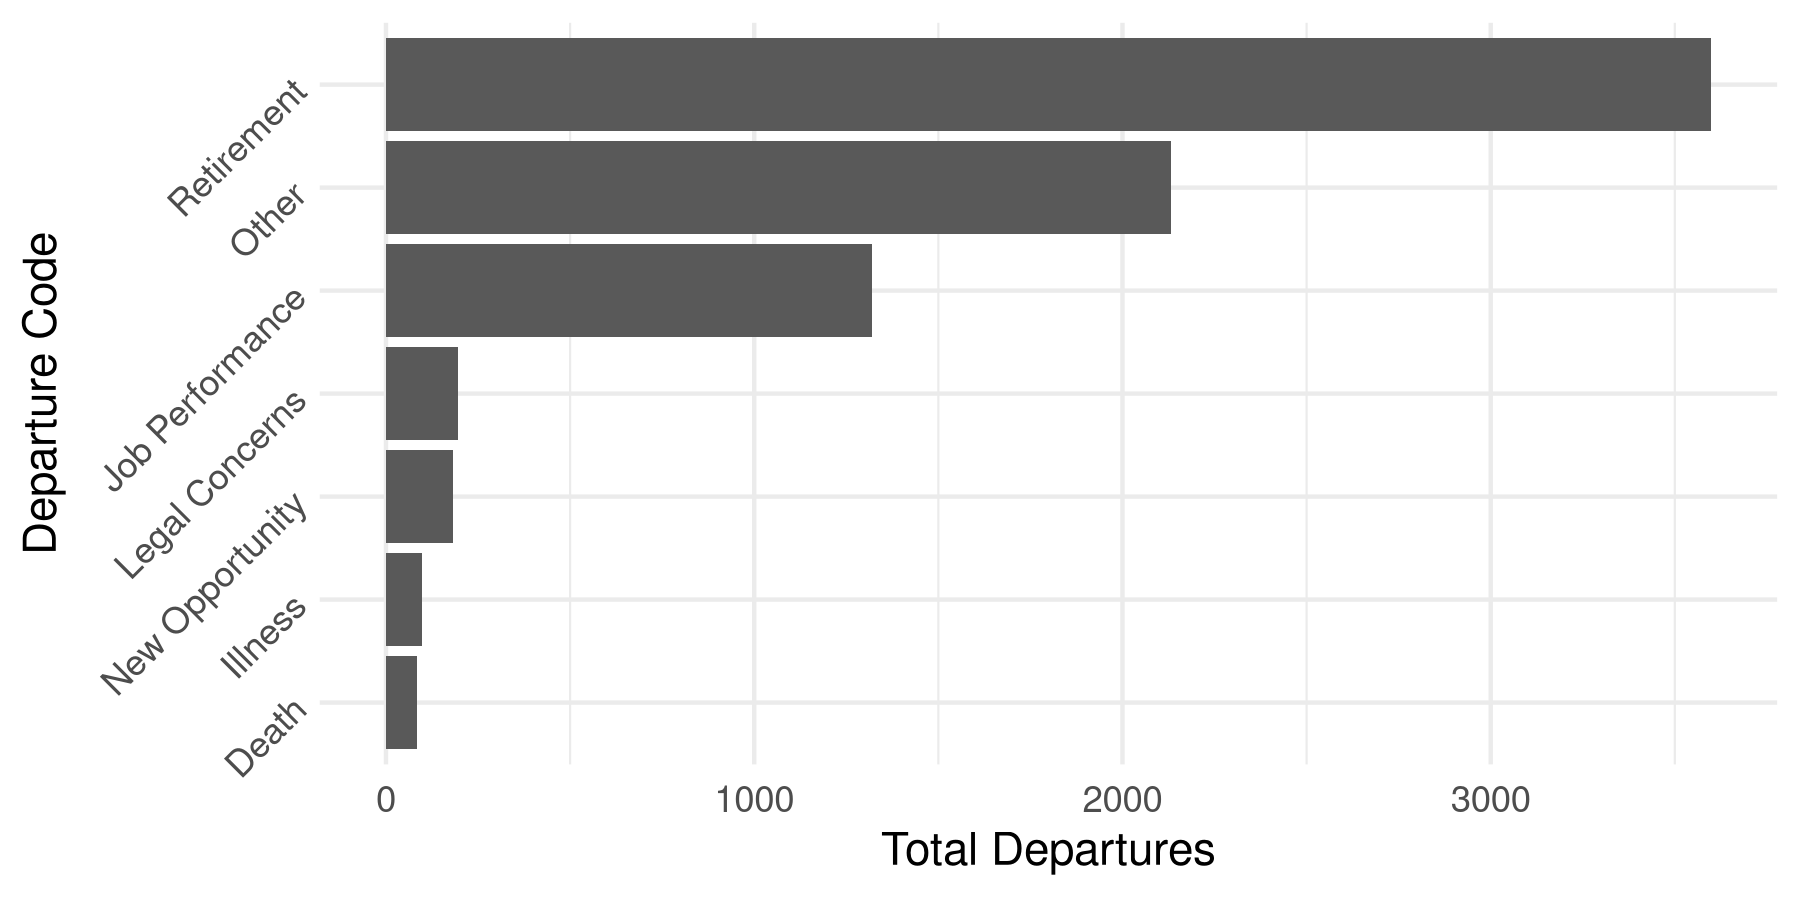

In [209]:
# mutate data to change departure_code to character
df_departure = df_original %>%
    filter(!is.na(departure_code), departure_code < 8) %>%
    mutate(departure_code = case_when(
        departure_code == 1 ~ "Death",
        departure_code == 2 ~ "Illness",
        departure_code == 3 ~ "Job Performance",
        departure_code == 4 ~ "Legal Concerns",
        departure_code == 5 ~ "Retirement",
        departure_code == 6 ~ "New Opportunity",
        departure_code == 7 ~ "Other",
        TRUE ~ "Unknown"))


# taking a look at top reasons for leaving
options(repr.plot.res = 300, repr.plot.height = 3, repr.plot.width = 6)
p = ggplot(df_departure, aes(y = departure_code %>% fct_infreq %>% fct_rev))

p = p + geom_bar()

p = p + labs(x = "Total Departures", y = "Departure Code")

p = p + theme_minimal()

p = p + theme(axis.text.y = element_text(angle = 45, hjust = 1))

p

   The aim of this initial bar chart is to get a feeling of what the CEO departure data looks like in terms of the reason for CEO departure. The data includes departure codes for each departure, which serves as the reason for departure coded in a numeric value that could be looked up on the [GitHub repo](https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-04-27/readme.md#ceo-departure-code). When looking at the reasons, reason 8 was missing data and reason 9 was "Execucomp error", and these were first filtered out along with missing values.
   I also converted the departure code variable to a short tag of the reason by using `case_when()`. I then plotted the departure reasons in decreasing count just to know why most CEOs leave companies, and the results indicate that the top three reasons in order, which far outweigh the others, are Voluntary Retirement, Other (Interim CEO, merger/acquisition, etc.), and Involuntary Performance Dismissal. I began to think about whether companies that have higher rates of departures also have similar or a common reason for CEO departure, and this is where I headed to next.

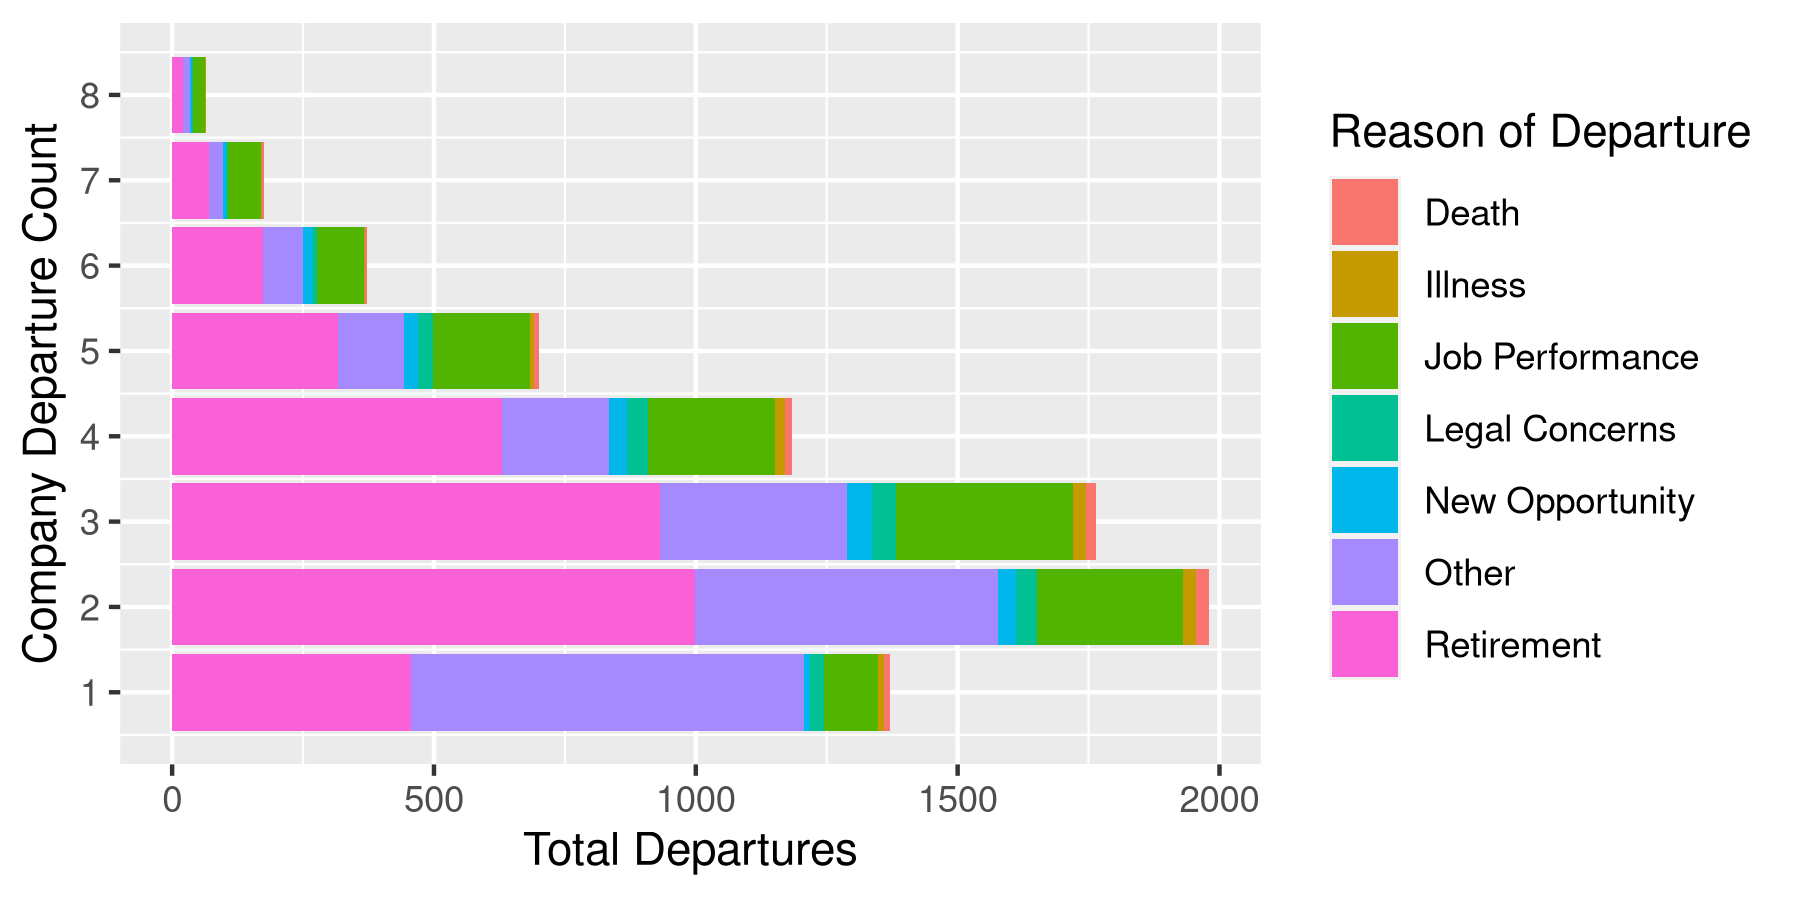

In [200]:
# getting company departure count
df_company_departure_count = df_departure %>% 
    group_by(coname) %>%
    summarize(company_count = n()) 

# joining with original data set to have each departure entry include count
df_departure_count = df_departure %>%
    inner_join(df_company_departure_count, by = "coname")


# plot bar graph colored by departure code with y axis as total count of departures per company
p = ggplot(df_departure_count, aes(y = company_count, fill = departure_code))

p = p + geom_bar()

p = p + scale_y_continuous(breaks = seq(1,11))

p = p + labs(x = "Total Departures", y = "Company Departure Count", fill = "Reason of Departure")

p

I first calculated each company's count of departures and added that data to every departure. Then, I decided to make a bar chart of the company departure count and see which departure counts were most and least common. Interestingly, the most common count was 2 departures rather than 1. To see whether there are trends in the reason of departure, I added coloring to represent the reason of departure. This chart did a great job of showing the numbers for why and where departures are taking place, but I needed to be able to compare the proportions of reasons between each category, and maybe see each reason by itself to notice trends in the data.

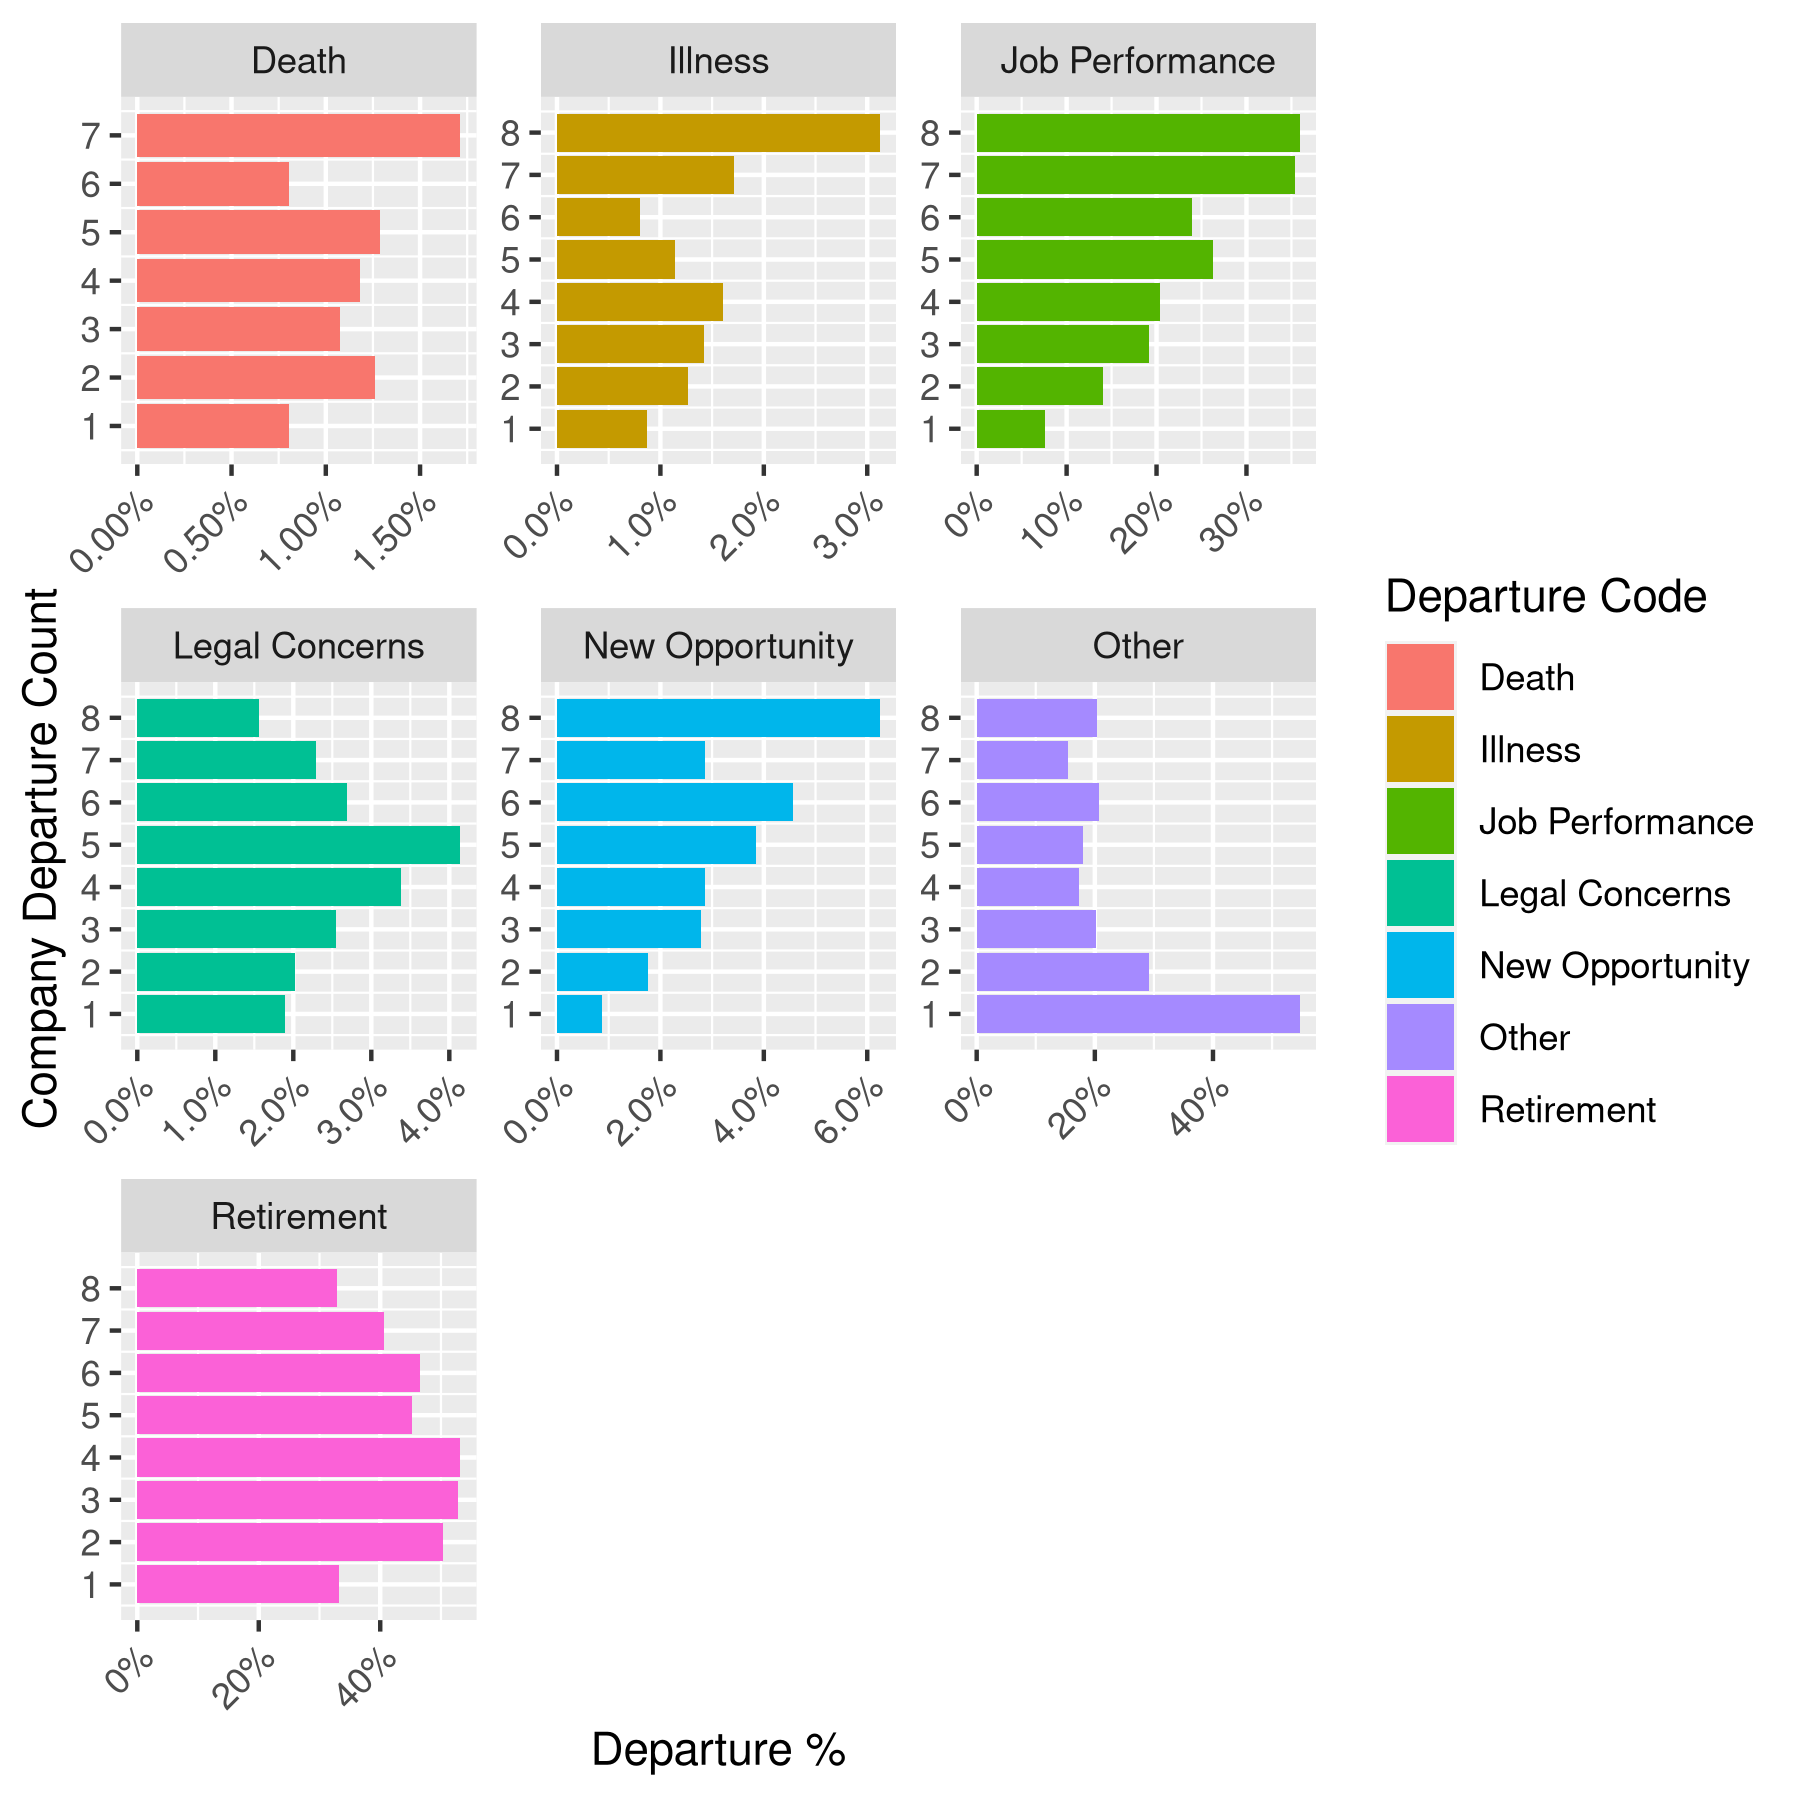

In [206]:
# get total count of departures per company departure count
df_total_company_count = df_departure_count %>% 
    group_by(company_count) %>% 
    summarize(total_company_count = n())

# combine with data set to get 'weight' of each departure in subsequent category
df_departure_count_total = df_departure_count %>%
    inner_join(df_total_company_count, by = "company_count") %>%
    mutate(weight = 1/total_company_count)

# plot bar graphs colored by reason with x axis as percent of departures in category
options(repr.plot.res = 300, repr.plot.height = 6, repr.plot.width = 6)

p = ggplot(df_departure_count_total, aes(y = company_count, weight = weight, fill = departure_code))

p = p + facet_wrap(~departure_code, scales = "free")

p = p + geom_bar()

p = p + scale_x_continuous(labels = percent)

p = p + scale_y_continuous(breaks = seq(1,11))

p = p + labs(x = "Departure %", y = "Company Departure Count", fill = "Departure Code")

p = p + theme(axis.text.x = element_text(angle = 45, hjust = 1))

p

   Finally, I got totals for each category of company departure count, and gave each departure a 'weight' representing its percent of the total departures in the category. I decided to go with a grid of graphs each representing a reason, and I made the scales free so that the trends can be observed on each level. Some interesting observations I made were: Departures due to other reasons like interim CEOs and acquisitions were more common among companies with less departures and departures due to new opportunities, job performance, & illness were more common among companies with higher departures.